# part 1: 


In [1]:
import os
import json
import shutil
import tempfile
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import nibabel as nib

from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai import transforms
from monai.transforms import (
    AsDiscrete,
    Activations,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.utils.enums import MetricReduction
from monai.networks.nets import SwinUNETR
from monai import data
from monai.data import decollate_batch
from functools import partial

import torch


print_config()

/home/xzhang/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


MONAI version: 1.3.0
Numpy version: 1.23.4
Pytorch version: 1.13.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /home/<username>/anaconda3/envs/swincell/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.2.1
scikit-image version: 0.19.3
scipy version: 1.9.3
Pillow version: 9.3.0
Tensorboard version: 2.16.2
gdown version: 4.7.3
TorchVision version: 0.14.1+cu117
tqdm version: 4.64.1
lmdb version: 1.4.1
psutil version: 5.9.8
pandas version: 1.3.4
einops version: 0.7.0
transformers version: 4.21.3
mlflow version: 2.11.1
pynrrd version: 1.0.0
clearml version: 1.14.5rc0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [35]:
from types import SimpleNamespace
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
args = SimpleNamespace(
    checkpoint=None,
    amp=False,
    batch_size=1,
    cellpose=True,
    max_epochs=5,
    optim_lr=1e-5,
    model='swin',
    num_workers=8,
    optimizer='adam',
    resume=None,
    save_temp_img=False,
    seed=0,
    test_mode=False,
    downsample_factor =3,
    threshold=0.5,
    weight_decay=0.0001,
    # ROI=(10, 10, 5),
    ROI=(64, 64, 32),
    workers=8
)



# test loading nanolive images 

In [36]:
from monai.transforms import  Transform, MapTransform
import torch
import numpy as np


class Cellpose_reshape(Transform):
    #split 4 channels

    # backend = [TransformBackends.TORCH, TransformBackends.NUMPY]
    def __call__(self, img):
        # if img has channel dim, squeeze it
        if img.ndim == 4 and img.shape[0] == 1:
            img = img.squeeze(0)
        result =np.array(np.split(img,4,axis=2))
        # result = np.uint8(result)
        result[0] = np.uint8(result[0]>0)
        result[1:] = (result[1:] - 127)/127
        # print('result shape',result.shape,result.dtype) #(4, 96, 512, 512)
        return result
class Cellpose_reshaped(MapTransform):


    # backend = Cellpose_reshape.backend

    def __init__(self, keys, allow_missing_keys: bool = False):
        super().__init__(keys, allow_missing_keys)
        self.converter = Cellpose_reshape()

    def __call__(self, data):
        d = dict(data)
        for key in self.key_iterator(d):
            d[key] = self.converter(d[key])
        return d

In [24]:
a =np.zeros((512, 512, 384),dtype=np.uint8)
# b = np.array(np.split(a,4,axis=2)) #(4, 512, 512, 96)
b = np.array(np.split(a,4,axis=2)) #(4, 512, 512, 96)
print(b.shape)

(4, 512, 512, 96)


In [37]:

import glob
from monai import data, transforms
import matplotlib.pyplot as plt
import torch
from swincell.utils.data_utils import flow_reshaped
data_dir = '/data/download_data/Nanolive_mem_cellpose_data_v5_nor_1_99/'
N = len(os.listdir(os.path.join(data_dir,'images')))


img_full_paths = sorted(glob.glob(os.path.join(data_dir,'images/*')))
label_full_paths = sorted(glob.glob(os.path.join(data_dir,'masks_with_flows/*.tiff')))
print(len(img_full_paths))

if len(img_full_paths)<5:
    img_full_paths = img_full_paths * 10
    label_full_paths = label_full_paths * 10
valid_img_full_paths = img_full_paths[::5]
valid_label_full_paths = label_full_paths[::5]

train_img_full_paths = [f for i,f in enumerate(img_full_paths) if i%5 != 0]
train_label_full_paths = [f for i,f in enumerate(label_full_paths) if i%5 != 0]


train_datalist = [{'image':image,'label':label} for image,label in zip(train_img_full_paths,train_label_full_paths)]    
val_datalist = [{'image':image,'label':label} for image,label in zip(valid_img_full_paths,valid_label_full_paths)]  

print(len(train_datalist),len(val_datalist))
# img_shape = (129, 1030, 1300)

img_shape = (512, 512,96)# nanolive XYZ
# COLON dataset shape unknown
img_reshape = (img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor,img_shape[2]//args.downsample_factor)
# img_reshape = (img_shape[-1]//args.downsample_factor,img_shape[0]//args.downsample_factor,img_shape[1]//args.downsample_factor)
img_reshape = tuple(int(e) for e in img_reshape)
train_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        transforms.EnsureChannelFirstd(keys=["image", "label"]),
        flow_reshaped(keys=["label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=img_reshape),
        # transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        # transforms.RandZoomd(keys=["image", "label"],prob=1,min_zoom=0.2,max_zoom=5),
        # transforms.ScaleIntensityRanged(
        #     keys=["image"], a_min=19000, a_max=31000, b_min=0, b_max=1, clip=True
        # ),
        transforms.RandSpatialCropSamplesd(
            keys=["image","label"],
            roi_size=[96,96,32],
            # roi_size=[128,128,32],
            num_samples=2,
            random_center=True,
            random_size=False,
        ),

        transforms.ToTensord(keys=["image", "label"]),
    ]
)
valid_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image", "label"]),
        # transforms.AsDiscreted(keys=["label"],threshold=1),
        # transforms.AddChanneld(keys=["image", "label"]),
        transforms.Resized(keys=["image", "label"],spatial_size=(512,512,96)),
        transforms.ScaleIntensityRanged(
            keys=["image"], a_min=21000, a_max=31000, b_min=0, b_max=1, clip=True
            # keys=["image"], a_min=300, a_max=400, b_min=0, b_max=1, clip=True
        ),
        transforms.ToTensord(keys=["image", "label"]),
    ]
)

train_ds = data.Dataset(data=train_datalist, transform=train_transform)
train_loader = data.DataLoader(
        train_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )
valid_ds = data.Dataset(data=val_datalist, transform=valid_transform)
valid_loader = data.DataLoader(
        valid_ds, batch_size=1, num_workers=8, sampler=None, drop_last=True
    )



10
8 2


torch.Size([2, 1, 96, 96, 32]) torch.Size([2, 4, 96, 96, 32])
metatensor(1.) metatensor(0.)
mask2 metatensor(1.0007) metatensor(-1.)
torch.Size([2, 1, 96, 96, 32]) torch.Size([2, 4, 96, 96, 32])
metatensor(1.) metatensor(0.)
mask2 metatensor(1.0007) metatensor(-1.)


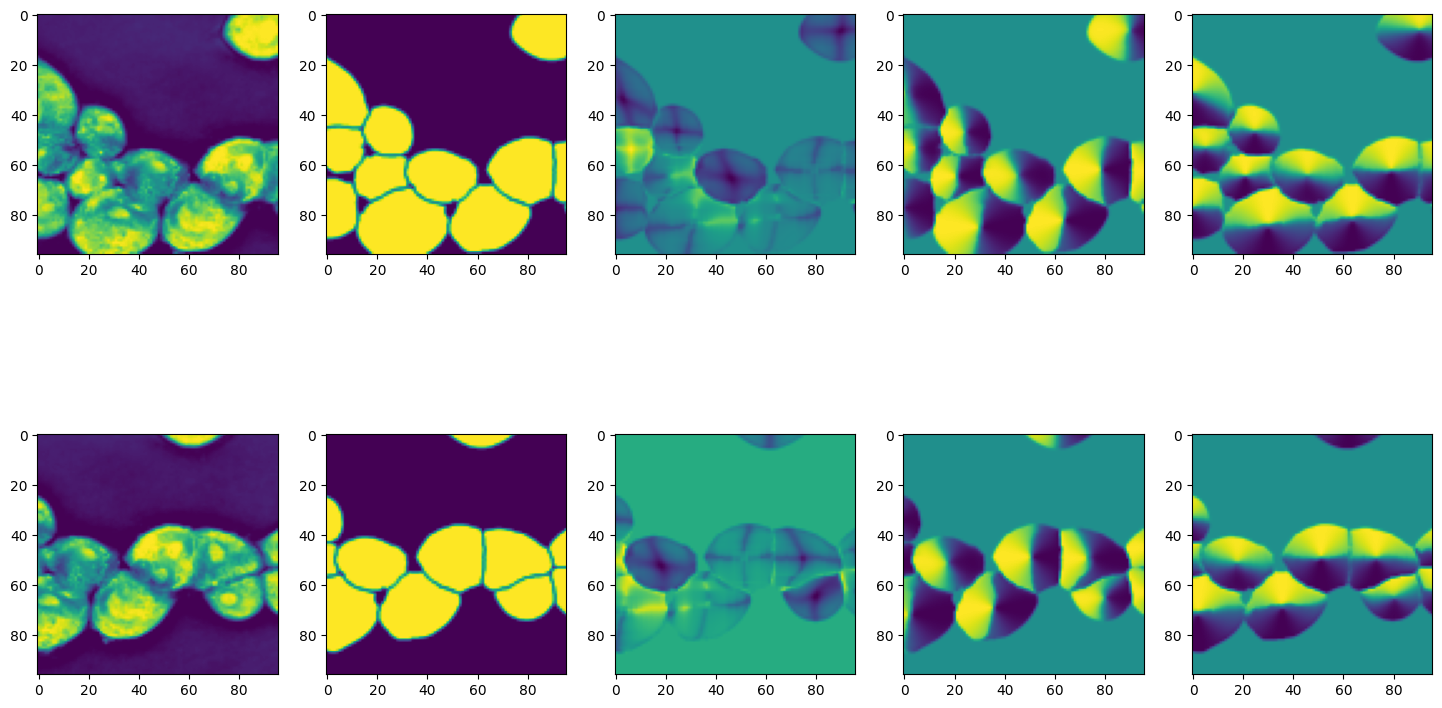

In [38]:
n_row = 2
fig, axes = plt.subplots(n_row, 5,sharex=False, sharey=False, figsize=(18,10))

slice2view = args.ROI[-1]//2
for i in range(n_row):
    datai = next(iter(train_loader))
    img2plot=datai['image']
    label2plot=datai['label']
    # img2plot,label2plot = next(iter(train_loader))
    print(img2plot.shape, label2plot.shape)

    top= torch.max(img2plot[0,0,:,:,:],dim=-1)[0].detach().cpu()

    # mask0= torch.max(label2plot[0,0,0,:,:,:],dim=-1)[0].detach().cpu()
    # mask1= torch.max(label2plot[0,0,1,:,:,:],dim=-1)[0].detach().cpu()
    # mask2= torch.max(label2plot[0,0,2,:,:,:],dim=-1)[0].detach().cpu()
    # mask3= torch.max(label2plot[0,0,2,:,:,:],dim=-1)[0].detach().cpu()

    mask0= label2plot[0,0,:,:,slice2view].detach().cpu()
    mask1= label2plot[0,1,:,:,slice2view].detach().cpu()
    mask2= label2plot[0,2,:,:,slice2view].detach().cpu()
    mask3= label2plot[0,3,:,:,slice2view].detach().cpu()

    # mask0= label2plot[0,0,slice2view].detach().cpu()
    # mask1= label2plot[0,1,slice2view].detach().cpu()
    # mask2= label2plot[0,2,slice2view].detach().cpu()
    # mask3= label2plot[0,3,slice2view].detach().cpu()

    print(mask0.max(),mask0.min())
    print('mask2',mask2.max(),mask2.min())
    axes[i,0].imshow(img2plot[0,0,:,:,slice2view])

    
    axes[i,1].imshow(mask0)
    axes[i,2].imshow(mask1)
    axes[i,3].imshow(mask2)
    axes[i,4].imshow(mask3)



In [40]:
from monai.networks.nets import SwinUNETR
from swincell.utils.utils import AverageMeter
model = SwinUNETR(
            img_size=args.ROI,
            in_channels=1,
            out_channels=4,
            # feature_size=48,
            feature_size=12,
            use_checkpoint=None,
        ).to(device)

from torch.nn import MSELoss,BCEWithLogitsLoss
from monai.losses import DiceLoss
loss1 = MSELoss(reduction='mean')
loss2 = DiceLoss(to_onehot_y=False, sigmoid=True)
# dice_loss2 = BCEWithLogitsLoss(reduction='mean')
losses = [loss1,loss2]

optimizer = torch.optim.SGD(
            model.parameters(), lr=args.optim_lr, momentum=0.99, nesterov=True, weight_decay=1e-5
        )
res =[]
# for epoch in range(args.max_epochs):
for epoch in range(25):
    model.train()
    run_loss = AverageMeter()
    for i, data in enumerate(train_loader):
        loss_func1 = losses[0]
        loss_func2 = losses[1]
        data, target = data['image'].to(device), data['label'].to(device)
        logits = model(data)
        # print(logits.shape,target.shape)
        #  weight_factor*flow loss     +      cell probability loss
        loss = 5*loss_func1(logits[:,1:], target[:,1:]) + loss_func2(logits[:,0], target[:,0])
        loss.backward()
        optimizer.step()
        run_loss.update(loss.item(), n=args.batch_size)
        res.append(loss.item())
        print('Epoch {}/{} {}/{}'.format(epoch, args.max_epochs, i, len(train_loader)), "loss: {:.4f}".format(run_loss.avg))

Epoch 0/5 0/8 loss: 2.1803
Epoch 0/5 1/8 loss: 2.0807
Epoch 0/5 2/8 loss: 2.0966
Epoch 0/5 3/8 loss: 2.1033
Epoch 0/5 4/8 loss: 2.0864
Epoch 0/5 5/8 loss: 2.0861
Epoch 0/5 6/8 loss: 2.0718
Epoch 0/5 7/8 loss: 2.0595
Epoch 1/5 0/8 loss: 1.8865
Epoch 1/5 1/8 loss: 1.8247
Epoch 1/5 2/8 loss: 1.8224
Epoch 1/5 3/8 loss: 1.8030
Epoch 1/5 4/8 loss: 1.7872
Epoch 1/5 5/8 loss: 1.7967
Epoch 1/5 6/8 loss: 1.7762
Epoch 1/5 7/8 loss: 1.7689
Epoch 2/5 0/8 loss: 1.6068
Epoch 2/5 1/8 loss: 1.5624
Epoch 2/5 2/8 loss: 1.5668
Epoch 2/5 3/8 loss: 1.5561
Epoch 2/5 4/8 loss: 1.5282
Epoch 2/5 5/8 loss: 1.5520
Epoch 2/5 6/8 loss: 1.5470
Epoch 2/5 7/8 loss: 1.5494
Epoch 3/5 0/8 loss: 1.5143
Epoch 3/5 1/8 loss: 1.4606
Epoch 3/5 2/8 loss: 1.4666
Epoch 3/5 3/8 loss: 1.4430
Epoch 3/5 4/8 loss: 1.4345
Epoch 3/5 5/8 loss: 1.4526
Epoch 3/5 6/8 loss: 1.4405
Epoch 3/5 7/8 loss: 1.4329
Epoch 4/5 0/8 loss: 1.3155
Epoch 4/5 1/8 loss: 1.2612
Epoch 4/5 2/8 loss: 1.2670
Epoch 4/5 3/8 loss: 1.2550
Epoch 4/5 4/8 loss: 1.2537
E

In [2]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
# from monai.transforms import RemoveSmallObjects,FillHoles
# from monai.transforms import FillHoles
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles
model_path = '/data/programs/monai_research_contributions/SwinUNETR/allen/runs/Nanolive_finetune3/foldNone/model_final.pt'
model = SwinUNETR(
    img_size=(96,96,96),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)



# print(val_output_convert.shape)


In [3]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(valid_loader):
            data_raw, target = batch_data["image"], batch_data["label"]
            data_raw, target = data_raw.cuda(0), target.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_raw)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())
            val_labels_list = target
            val_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(val_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            val_output_convert1 = post_pred(post_sigmoid(val_outputs_list))
            val_output_convert2 = post_trans(logits)
            print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

tensor(268.0057, device='cuda:0') tensor(-16.6058, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1402e-08, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(268.0057, device='cuda:0') tensor(-16.6058, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1402e-08, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')
tensor(232.3488, device='cuda:0') tensor(-15.7250, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(1.4816e-07, device='cuda:0') tensor(0.0005, device='cuda:0')
tensor(1., device='cuda:0') tensor(0., device='cuda:0') tensor(0., device='cuda:0')


# test inference

In [27]:
root_dir = '/data/download_data/quilt-data-access-tutorials-main/all_fov/'
df = pd.read_csv(root_dir+'meta_info.csv')

# input_dir=df['fov_path'].unique()[100:220].tolist()
# target_dir=df['fov_seg_path'].unique()[100:220].tolist()
# train_img_paths =input_dir[:100]
# train_label_paths = target_dir[:100]
# valid_img_paths =input_dir[100:]
# valid_label_paths = target_dir[100:]

input_dir=df['fov_path'].unique()[300:320].tolist()
# target_dir=df['fov_seg_path'].unique()[:20].tolist()
train_img_paths =input_dir[:20]



train_img_full_paths =[os.path.join(root_dir,'fov_path_channel/'+file.split('/')[-1]) for file in train_img_paths]





test_datalist = [{'image':a} for a in train_img_full_paths] 
test_transform = transforms.Compose(
    [
        transforms.LoadImaged(keys=["image"]),
        transforms.AddChanneld(keys=["image"]),
        transforms.Resized(keys=["image"],spatial_size=(512,512,96)),
        # transforms.ScaleIntensityRanged(
        #     keys=["image"], a_min=18000, a_max=26000, b_min=0, b_max=1, clip=True
        # ),
        transforms.ToTensord(keys=["image"]),
    ]
)

test_ds = data.Dataset(data=test_datalist, transform=test_transform)
test_loader = data.DataLoader(
        test_ds, batch_size=1, num_workers=24, sampler=None, drop_last=True
    )

Columns (34) have mixed types. Specify dtype option on import or set low_memory=False.


In [28]:
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from functools import partial
# from monai.transforms import RemoveSmallObjects,FillHoles
# from monai.transforms import FillHoles
from monai.transforms import Activations, AsDiscrete, Compose,FillHoles
model_path = '/data/programs/monai_research_contributions/SwinUNETR/allen/runs/Nanolive_finetune3/foldNone/model_final.pt'
model = SwinUNETR(
    img_size=(96,96,96),
    in_channels=1,
    out_channels=1,
    feature_size=48,
    use_checkpoint=False,
).cuda(0)
model_dict = torch.load(model_path)["state_dict"]
model.load_state_dict(model_dict)


model_inferer = partial(
    sliding_window_inference,
    roi_size=(96,96,96),
    # roi_size=(128,128,96),

    sw_batch_size=2,
    predictor=model,
    overlap=0.5,
)
post_sigmoid = Activations(sigmoid=True)
# post_pred = AsDiscrete(argmax=False, logit_thresh=1.01)
post_pred = AsDiscrete(argmax=False, threshold=0.6)

In [31]:
post_trans = Compose([
    Activations(sigmoid=True),
    AsDiscrete(argmax=False, threshold=0.5),
    # RemoveSmallObjects(min_size = 100),
    FillHoles(applied_labels=None, connectivity=2)

])

with torch.no_grad():
        for idx, batch_data in enumerate(test_loader):
            data_test = batch_data["image"]
            data_test = data_test.cuda(0)
            # with autocast(enabled=True):
            logits = model_inferer(data_test)
            # val_labels_list = decollate_batch(target)
            # val_outputs_list = decollate_batch(logits)
            print(logits.max(),logits.min())

            test_outputs_list = logits
            # val_output_convert = [post_pred(post_sigmoid(val_pred_tensor)) for val_pred_tensor in val_outputs_list]
            a = post_sigmoid(test_outputs_list)
            print('after sigmoid',a.max(),a.min(),a.median())
            test_output_convert1 = post_pred(post_sigmoid(test_outputs_list))
            test_output_convert2 = post_trans(logits)
            # print(val_output_convert1.max(),val_output_convert1.min(),val_output_convert1.median())

tensor(107.0293, device='cuda:0') tensor(-12.1564, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(5.2544e-06, device='cuda:0') tensor(0.0052, device='cuda:0')
tensor(85.8323, device='cuda:0') tensor(-15.6975, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(1.5228e-07, device='cuda:0') tensor(0.0061, device='cuda:0')
tensor(49.4350, device='cuda:0') tensor(-14.2095, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.7435e-07, device='cuda:0') tensor(0.0054, device='cuda:0')
tensor(71.0185, device='cuda:0') tensor(-12.2007, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(5.0267e-06, device='cuda:0') tensor(0.0056, device='cuda:0')
tensor(49.4618, device='cuda:0') tensor(-12.0011, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tensor(6.1371e-06, device='cuda:0') tensor(0.0057, device='cuda:0')
tensor(43.2879, device='cuda:0') tensor(-11.9350, device='cuda:0')
after sigmoid tensor(1., device='cuda:0') tenso

In [86]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()